In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.

def b_init(shape,name=None):
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,
                   kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,
                   kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),
                  kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
optimizer = SGD(0.00004,momentum=0.65,nesterov=True,decay=0.0003)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


38951745

In [7]:
with open( "/home/soren/keras-oneshot/train.pickle","r") as f:
    (X,y,c) = pickle.load(f)

with open( "/home/soren/keras-oneshot/val.pickle","r") as f:
    (Xval,yval,cval) = pickle.load(f)
#a=siamese_net.predict([X[1,1,:,:].reshape(1,105,105,1),X[7,1,:,:].reshape(1,105,105,1) ])
#b=siamese_net.predict([X[7,1,:,:].reshape(1,105,105,1),X[1,1,:,:].reshape(1,105,105,1) ])


In [8]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,Xtrain,Xval=None):
        if Xval is None:
		self.Xval = Xtrain 
	else:
       		self.Xval = Xval# / Xval.max()
        self.Xtrain = Xtrain# / Xtrain.max()


        self.n_classes,self.n_examples,self.w,self.h = Xtrain.shape
        self.n_val,self.n_ex_val,_,_ = self.Xval.shape

    def get_batch(self,n):
        """Create batch of n pairs, half same class, half different class"""
        categories = rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = self.Xtrain[category,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1,self.n_classes)) % self.n_classes
            pairs[1][i,:,:,:] = self.Xtrain[category_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets

    def make_oneshot_task(self,N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        categories = rng.choice(self.n_val,size=(N,),replace=False)
        indices = rng.randint(0,self.n_ex_val,size=(N,))
        true_category = categories[0]
        ex1, ex2 = rng.choice(self.n_examples,replace=False,size=(2,))
        test_image = np.asarray([self.Xval[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = self.Xval[categories,indices,:,:]
        support_set[0,:,:] = self.Xval[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        pairs = [test_image,support_set]
        targets = np.zeros((N,))
        targets[0] = 1
        return pairs, targets
    
    def test_oneshot(self,model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct



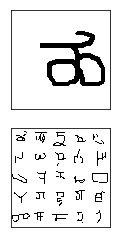

In [13]:
loader = Siamese_Loader(X,Xval)

def concat_images(X):
    """Concatenates a bnch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(25)
plot_oneshot_task(pairs)


In [11]:
evaluate_every = 7000
loss_every=300
batch_size = 32
N_way = 20
n_val = 550
best = 76.0
for i in range(900000):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        


FailedPreconditionError: Attempting to use uninitialized value conv2d_1/kernel
	 [[Node: conv2d_1/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@conv2d_1/kernel"], _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_1/kernel)]]

Caused by op u'conv2d_1/kernel/read', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-869b267873dd>", line 28, in <module>
    kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 430, in add
    layer(x)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 551, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 384, in add_weight
    weight = K.variable(initializer(shape), dtype=K.floatx(), name=name)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 288, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 344, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv2d_1/kernel
	 [[Node: conv2d_1/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@conv2d_1/kernel"], _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_1/kernel)]]


In [ ]:
siamese_net.load_weights("/home/soren/keras-oneshot/weights")
val_acc = loader.test_oneshot(siamese_net,20,1500,verbose=True)
